In [1]:
import pandas as pd
import neighborhoodAnalysis as nha
import numpy as np
from tqdm import tqdm
import os
from joblib import Parallel, delayed
import pickle
import util

In [2]:
# Load proximity dataframe
proxi_df = pd.read_csv(r'.\results\proxi_df.csv',index_col=0)

In [9]:
# Find row, col, z center of each patch
df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df'
cell_l = os.listdir(df_dir)
cell_l.sort()

row = np.zeros(proxi_df.shape[0])
col = np.zeros(proxi_df.shape[0])
z = np.zeros(proxi_df.shape[0])
i = 0
for cell in tqdm(cell_l):
    if cell.endswith('.csv'):
        cell_df = pd.read_csv(os.path.join(df_dir, cell))
        
        cell_by_patch = cell_df.groupby('patch')
        patches = np.sort(cell_df['patch'].unique())
        for p in patches:
            sub_group = cell_by_patch.get_group(p)
            row[i] = sub_group['row'].mean()
            col[i] = sub_group['col'].mean()
            z[i] = sub_group['z'].mean()
            i = i + 1

100%|████████████████████████████████████████████████████████████████████████████████| 554/554 [00:30<00:00, 18.47it/s]


In [10]:
proxi_df.insert(loc=proxi_df.shape[1],column='row',value=row)
proxi_df.insert(loc=proxi_df.shape[1],column='col',value=col)
proxi_df.insert(loc=proxi_df.shape[1],column='z',value=z)

In [12]:
# Find connected pairs within the same cell.
cell_ids = []
for item in proxi_df.index.tolist():
    temp = item.split('_')
    cell_ids.append(temp[0]+'_'+temp[1]+'_'+temp[2])

In [13]:
proxi_df.insert(loc=proxi_df.shape[1],column='cellID',value=cell_ids)

In [29]:
proxi_df.insert(loc=proxi_df.shape[1],column='patch_name',value=proxi_df.index.tolist())

In [33]:
proxi_df = proxi_df.reset_index()

In [36]:
proxi_df.to_csv(r'.\results\proxi_df.csv')

In [5]:
proxi_by_cell = proxi_df.groupby('cellID')
cells = list(np.sort(proxi_df['cellID'].unique()))
connected_pairs = Parallel(n_jobs=4)(delayed(nha.find_connected_pairs)(proxi_by_cell.get_group(i),
                                                                       5,'row','col','z') for i in cells)

In [35]:
with open(r'.\results\patch_connected_pairs.pkl', 'wb') as f:
    pickle.dump(connected_pairs, f)

In [95]:
# Patch count feature matrix
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df'
df_l = os.listdir(cell_df_dir)
df_l.sort()

In [96]:
patch_count_l = []
for fn in tqdm(df_l):
    if not fn.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(cell_df_dir, fn), index_col=0)
    df.insert(loc=df.shape[1], column='patch_id',value=df['cellID']+'_'+df['patch'].astype('str'))
    patch_count = util.counting(df,count_by='patch_id',gene_name='gene')
    patch_count_l.append(patch_count)

100%|████████████████████████████████████████████████████████████████████████████████| 554/554 [02:11<00:00,  4.21it/s]


In [97]:
patch_count = pd.concat(patch_count_l)

In [98]:
patch_count = patch_count.set_index(patch_count['Count_id'])

In [99]:
patch_count.index.name=None

In [76]:
proxi_df = proxi_df.set_index(proxi_df['index'])
proxi_df.index.name=None

In [78]:
features = pd.concat([proxi_df, patch_count], axis=1)

In [91]:
features = features.reset_index()

In [92]:
features.to_csv(r'.\results\feature_df.csv')

# Plotting patches

In [119]:
import tifffile
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

In [104]:
proxi_df = pd.read_csv(r'.\results\proxi_df.csv',index_col=0)

In [129]:
connected_pairs = pd.read_pickle(r'.\results\patch_connected_pairs.pkl')

In [174]:
proxi_by_cell = proxi_df.groupby('cellID')
bm_007_13 = proxi_by_cell.get_group('bm_007_13')

## Load dapi image

In [113]:
scale = 249.6/2304
z_scale = 0.3/1

In [114]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\masks\007_mask.tif')
mask = (mask==13).astype('int')

dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\imgs\007_image.tif')
dapi_mip = dapi_mip[2,:,:]

masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

dapi_z = 12 * z_scale

In [175]:
index = proxi_df['cellID'].unique().tolist().index('bm_007_13')
connected_pairs = connected_pairs[index]

In [176]:
# bm_007_13 = bm_007_13[bm_007_13['z']<20]

In [177]:
connected_pairs = nha.find_connected_pairs(bm_007_13,5,'row','col','z')

In [178]:
edge_row = []
edge_col = []
edge_z = []
for item in connected_pairs:
    edge_row.append(proxi_df.iloc[item[0]]['row'].astype('float'))
    edge_row.append(proxi_df.iloc[item[1]]['row'].astype('float'))
    edge_row.append(None)
    
    edge_col.append(proxi_df.iloc[item[0]]['col'].astype('float'))
    edge_col.append(proxi_df.iloc[item[1]]['col'].astype('float'))
    edge_col.append(None)
    
    edge_z.append(proxi_df.iloc[item[0]]['z'].astype('float'))
    edge_z.append(proxi_df.iloc[item[1]]['z'].astype('float'))
    edge_z.append(None)

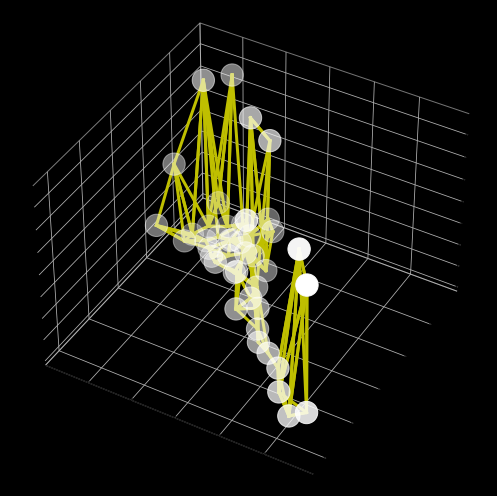

In [182]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',color='w', s=500)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
            [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
            [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_patch_networks_no_dapi.png')

In [231]:
patches = ['16','19','26','33']

In [246]:
sub_df = []
for i in bm_007_13.index.tolist():
    temp = bm_007_13.loc[i]['patch_name'].split('_')[-1]
    if temp in patches:
        sub_df.append(bm_007_13.loc[i])

In [247]:
sub_df = pd.concat(sub_df, axis=1)

In [248]:
sub_df

,2845,2848,2855,2862
index,bm_007_13_16,bm_007_13_19,bm_007_13_26,bm_007_13_33
ACAN_ACTb,-0.221175,1.427929,-1.614883,0.176944
ACAN_ALPL,-0.777561,-0.59106,-0.279972,0.0
ACAN_CCL11,-1.417616,-0.733962,1.039545,-1.204272
ACAN_CCL19,0.0,-0.585482,-0.303309,1.623333
...,...,...,...,...
row,1328.343195,1307.537975,1273.996283,1301.280788
col,307.227811,341.268987,293.096654,311.068966
z,13.662722,9.981013,10.159851,10.019704
cellID,bm_007_13,bm_007_13,bm_007_13,bm_007_13


In [252]:
[sub_df.loc['row'][2845].astype('float')*scale, sub_df.loc['row'][2848].astype('float')*scale]

[143.90384615384616, 141.64994725738396]

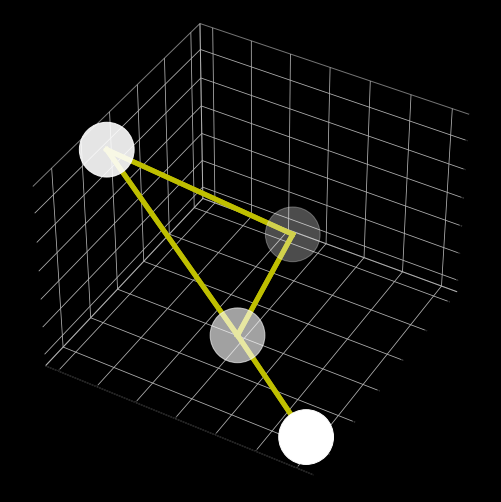

In [255]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.1)
ax.scatter(sub_df.loc['row']*scale, sub_df.loc['col']*scale,sub_df.loc['z']*z_scale,'.',color='w', s=3000)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    if (not item[0] in sub_df.columns.tolist()) or (not item[1] in sub_df.columns.tolist()):
        continue
    ax.plot([sub_df.loc['row'][item[0]].astype('float')*scale, sub_df.loc['row'][item[1]].astype('float')*scale],
            [sub_df.loc['col'][item[0]].astype('float')*scale, sub_df.loc['col'][item[1]].astype('float')*scale],
            [sub_df.loc['z'][item[0]].astype('float')*z_scale, sub_df.loc['z'][item[1]].astype('float')*z_scale],
            color='y',linewidth=5)
ax.axis('on')
# ax.set_xlim(140,150)
# ax.set_ylim(30,40)
# ax.set_zlim(15, 2)
ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_local_network.png')

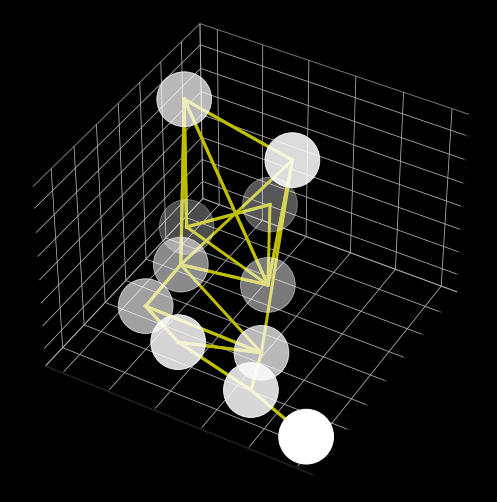

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.1)
ax.scatter(sub_df['row']*scale, sub_df['col']*scale,sub_df['z']*z_scale,'.',color='w', s=3000)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    if (not item[0] in sub_df.index.tolist()) or (not item[1] in sub_df.index.tolist()):
        continue
    ax.plot([sub_df.loc[item[0]]['row'].astype('float')*scale, sub_df.loc[item[1]]['row'].astype('float')*scale],
            [sub_df.loc[item[0]]['col'].astype('float')*scale, sub_df.loc[item[1]]['col'].astype('float')*scale],
            [sub_df.loc[item[0]]['z'].astype('float')*z_scale, sub_df.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)
ax.axis('on')
# ax.set_xlim(140,150)
# ax.set_ylim(30,40)
# ax.set_zlim(15, 2)
ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_zoomed_patch_network.png')

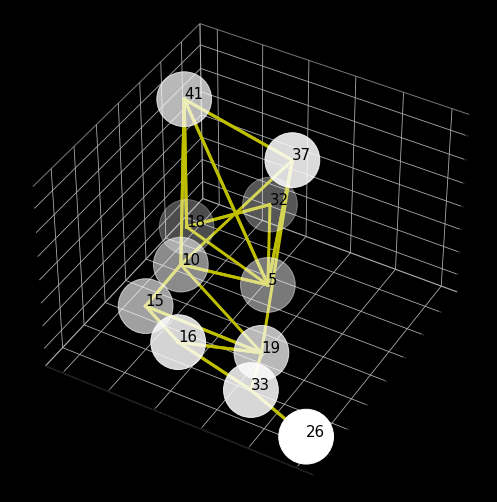

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.1)
ax.scatter(sub_df['row']*scale, sub_df['col']*scale,sub_df['z']*z_scale,'.',color='w', s=3000)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for i in sub_df.index.tolist():
    s = sub_df.loc[i]['patch_name'].split('_')[-1]
    ax.text(sub_df.loc[i]['row']*scale, sub_df.loc[i]['col']*scale, sub_df.loc[i]['z']*z_scale,s=s,fontsize=15)

for item in connected_pairs:
    if (not item[0] in sub_df.index.tolist()) or (not item[1] in sub_df.index.tolist()):
        continue
    ax.plot([sub_df.loc[item[0]]['row'].astype('float')*scale, sub_df.loc[item[1]]['row'].astype('float')*scale],
            [sub_df.loc[item[0]]['col'].astype('float')*scale, sub_df.loc[item[1]]['col'].astype('float')*scale],
            [sub_df.loc[item[0]]['z'].astype('float')*z_scale, sub_df.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)
ax.axis('on')
# ax.set_xlim(140,150)
# ax.set_ylim(30,40)
# ax.set_zlim(15, 2)
ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_zoomed_patch_label.png')